# Time Series Pattern Recognition with Air Quality Sensor Data

* 1. Introduction
* 2. Exploratory Data Analysis
    * 2.1 Pattern Changes
    * 2.2 Correlation Between Features
* 3. Anomaly Detection and Pattern Recognition
    * 3.1 Point Anomaly Detection (System Fault)
    * 3.2 Collective Anomaly Detection (External Event)
    * 3.3 Clustering and Pattern Recognition (External Event)
* 4. Conclusion
    * References
    * Appendix — Scatter Matrix of Selected Features
    * About Me

# 1. Introduction
This project is part of my freelance data science work for a client. There is no non-disclosure agreement required and the project does not contain any sensitive information. So, I decided to showcase the data analysis and modeling sections of the project as part of my personal data science portfolio. The client’s information has been anonymized.
In the project, two datasets are provided, each consists of one week of air quality sensor readings. They are provided to accomplish the following four tasks:

    1. Find anomalies in the data set to automatically flag events
    2. Categorize anomalies as “System fault” or “external event”
    3. Provide any other useful conclusions from the pattern in the data set
    4. Visualize inter-dependencies of the features in the dataset
In this report I am going to briefly walk through the steps I use for data analysis, visualization of feature correlation, machine learning techniques to automatically flag “system faults” and “external events” and my findings from the data.

# 2. Exploratory Data Analysis

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
from collections import Counter

## Concat tables

In [43]:
d1 = pd.read_csv('data/SL132001-data (11).csv')
d2 = pd.read_csv('data/SL132001-data (12).csv')

In [44]:
data = pd.concat([d1.iloc[1:], d2[1:]], axis=0, ignore_index=True)
data

,Date,Time GMT -4,Timestamp,Ozone - Low Conc.,Hydrogen Sulfide - Low Conc.,Total VOCs (ppm) - PID,Carbon Dioxide - Low Conc.,Particulate Matter 1,Particulate Matter 2.5,Particulate Matter 10,Temperature (Internal),Humidity (Internal),Temperature (External),Humidity (External),Latitude,Longitude,Unnamed: 16
0,26/05/2020,8:51:45,1590497505000,0.210,0.000,0.266,466.607,18.270,19.519,19.759,23.87,45.76,23.25,47.54,43.962193,-79.267792,NaN
1,26/05/2020,8:52:44,1590497564000,0.217,0.001,0.268,467.189,14.326,15.149,15.149,23.81,45.93,23.18,47.75,43.962193,-79.267792,NaN
2,26/05/2020,8:53:44,1590497624000,0.222,0.001,0.269,468.038,10.830,11.453,11.453,23.91,45.94,23.25,47.84,43.962193,-79.267792,NaN
3,26/05/2020,8:54:44,1590497684000,0.209,0.001,0.270,473.823,11.914,12.798,13.038,23.85,45.89,23.31,47.87,43.962193,-79.267792,NaN
4,26/05/2020,8:55:43,1590497743000,0.208,0.001,0.269,477.804,13.232,13.992,13.992,24,46.43,23.29,47.91,43.962193,-79.267792,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19739,09/06/2020,8:43:11,1591706591000,0.392,0.000,0.188,382.270,5.949,6.611,6.922,25.84,38.98,22.85,46.14,43.962193,-79.267792,NaN
19740,09/06/2020,8:44:10,1591706650000,0.363,0.000,0.190,379.761,6.446,7.245,7.661,25.87,38.96,22.94,45.35,43.962193,-79.267792,NaN
19741,09/06/2020,8:48:25,1591706905000,0.398,0.000,0.180,381.082,4.432,5.080,5.462,25.86,38.81,23,43.47,43.962193,-79.267792,NaN
19742,09/06/2020,8:49:03,1591706943000,0.428,0.000,0.179,387.501,6.207,7.307,8.094,25.83,38.92,23,44.26,43.962193,-79.267792,NaN


## Trim data

I first import and concatenate them into one Pandas dataframe in Python. Some rearrangements are made to remove columns except the 11 features that we are interested in:
* Ozone
* Hydrogen Sulfide
* Total VOCs
* Carbon Dioxide
* PM 1
* PM 2.5
* PM 10
* Temperature (Internal & External)
* Humidity (Internal & External).


The timestamps span from May 26 to June 9, 2020 (14 whole days in total) in EDT (GMT-4) time zone. By subtraction, different intervals are found between each reading, ranging from 7 seconds to 3552 seconds. The top 5 frequent time intervals are listed below in Table 1, where most of them are close to 59 and 60 seconds, so it can be concluded that the sensor reads every minute. However, the inconsistency of reading intervals might be worth looking into if it is no deliberate interference involved since it might cause trouble in future time series analysis.


In [45]:
# Drop columns
data.drop(columns=['Date', 'Time GMT -4', 'Latitude', 'Longitude', 'Unnamed: 16'], inplace=True)

In [46]:
# Conver timestamp
data['Timestamp'] = pd.to_datetime(data.Timestamp, unit='ms')
data.set_index('Timestamp', inplace=True)
data.index = data.index.tz_localize('UTC').tz_convert('US/Eastern')
data.head()

,Ozone - Low Conc.,Hydrogen Sulfide - Low Conc.,Total VOCs (ppm) - PID,Carbon Dioxide - Low Conc.,Particulate Matter 1,Particulate Matter 2.5,Particulate Matter 10,Temperature (Internal),Humidity (Internal),Temperature (External),Humidity (External)
Timestamp,,,,,,,,,,,
2020-05-26 08:51:45-04:00,0.210,0.000,0.266,466.607,18.270,19.519,19.759,23.87,45.76,23.25,47.54
2020-05-26 08:52:44-04:00,0.217,0.001,0.268,467.189,14.326,15.149,15.149,23.81,45.93,23.18,47.75
2020-05-26 08:53:44-04:00,0.222,0.001,0.269,468.038,10.830,11.453,11.453,23.91,45.94,23.25,47.84
2020-05-26 08:54:44-04:00,0.209,0.001,0.270,473.823,11.914,12.798,13.038,23.85,45.89,23.31,47.87
2020-05-26 08:55:43-04:00,0.208,0.001,0.269,477.804,13.232,13.992,13.992,24,46.43,23.29,47.91


In [47]:
intervals = []
for i in range(1, len(data.index)):
    intervals.append((data.index[i] - data.index[i-1]).seconds)

In [48]:
cnt = Counter(intervals)
df_cnt = pd.DataFrame(sorted(cnt.items(), key=lambda x: x[1], reverse=True))
df_cnt.columns = ['Interval (s)', 'Counts']
df_cnt.head(5)

,Interval (s),Counts
0,59,9279
1,60,8243
2,61,314
3,58,211
4,38,145


In [49]:
print(min(intervals), max(intervals))

7 3552


For each of the features, the time series data are on different scales, so they are normalized in order for better visualization and machine learning efficiencies. Then they are plotted and visually inspected to discover any interesting patterns.

## Exploration

### Time series (Unormalized and Normalized)

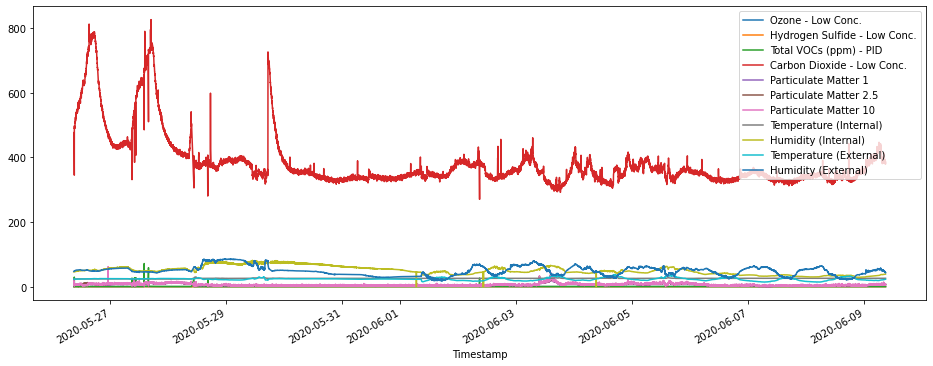

In [50]:
# Plot each feature vs time
fig, ax = plt.subplots(figsize=(16, 6))
for col in data.columns:
    data[col] = data[col].astype('float64')    
    data.plot(y=col, use_index=True, ax=ax)
plt.show()

In [51]:
# scaler = StandardScaler()
scaler = RobustScaler()
#scaler = MinMaxScaler()
data_norm = data.copy()
data_norm[:] = scaler.fit_transform(data_norm)

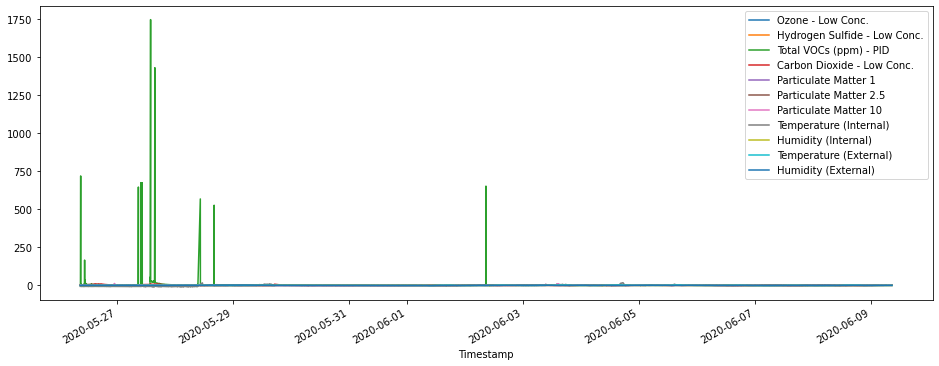

In [52]:
# Plot each feature (normalized) vs time
fig, ax = plt.subplots(figsize=(16, 6))
for col in data_norm.columns:
    data_norm[col] = data_norm[col].astype('float64')    
    data_norm.plot(y=col, use_index=True, ax=ax)
plt.show()

Some of the features seem to share similar pattern changes at specific time points. Three of the most significant ones (Temperature External, Humidity External, and Ozone) are shown below in Figure 1. It can be clearly seen that the areas highlighted with pink tend to have flat signals while the unhighlighted areas are sinusoidal.

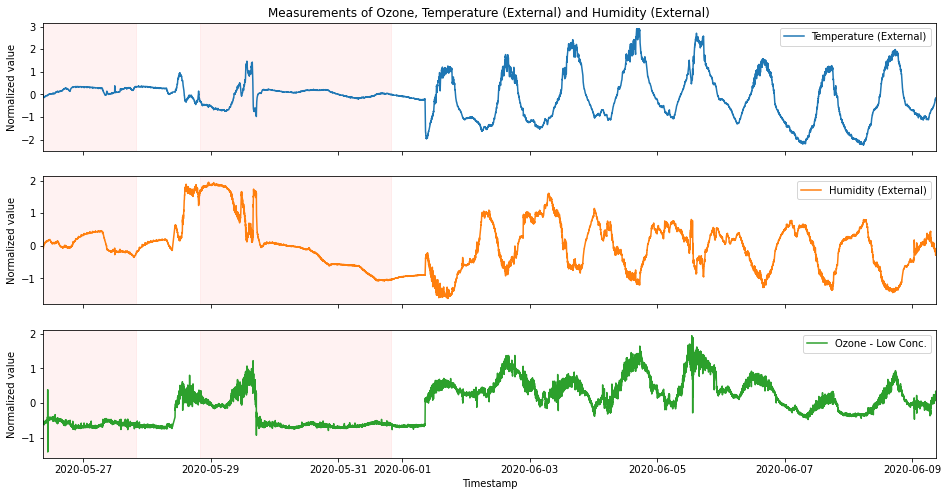

In [54]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 8))
cols = [9, 10, 0]
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(3):
    ax = axs[i]
    col = data_norm.columns[cols[i]]
    ax.plot(data_norm.index, data_norm[col], color=colors[i], label=col)
    ax.set_ylabel('Normalized value')
    ax.set_xlim([data_norm.index[0], data_norm.index[-1]])
    ax.legend()
    ax.axvspan('2020-05-26', '2020-05-28', alpha=0.05, color='red')
    ax.axvspan('2020-05-29', '2020-06-01', alpha=0.05, color='red')
axs[0].set_title('Measurements of Ozone, Temperature (External) and Humidity (External)')
plt.xlabel('Timestamp')
plt.show()

### Time Series of Single Plots

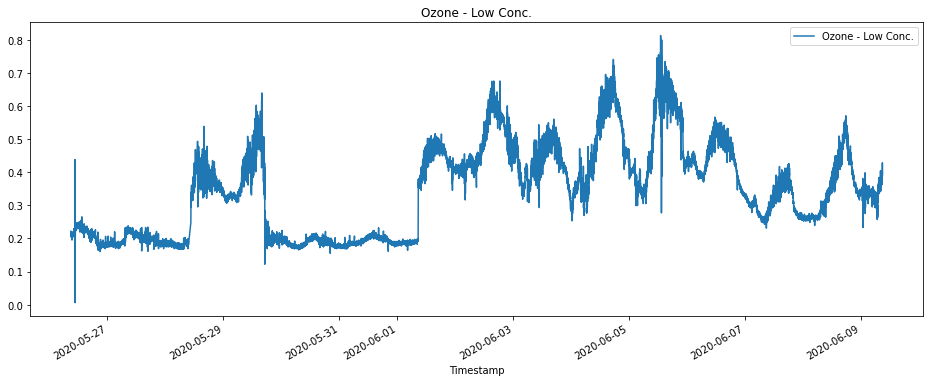

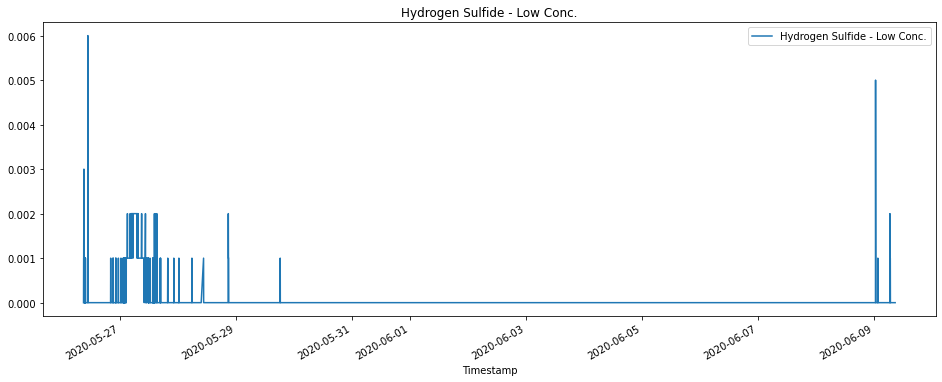

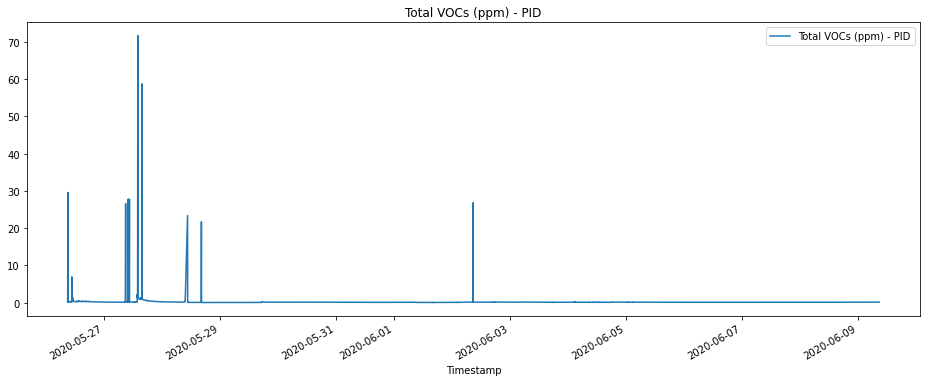

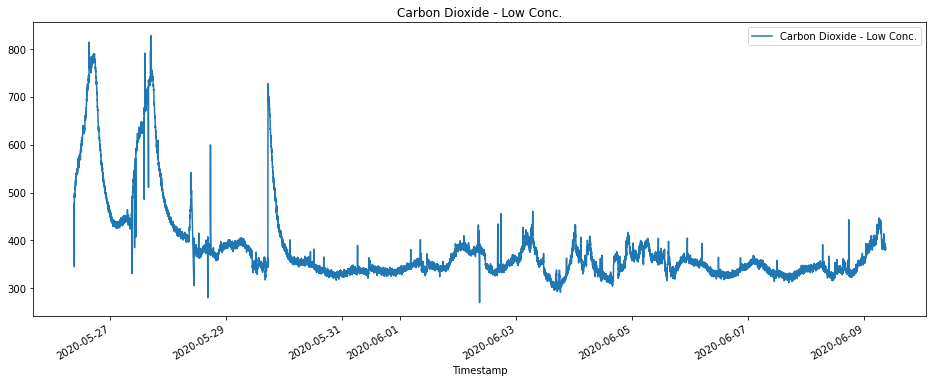

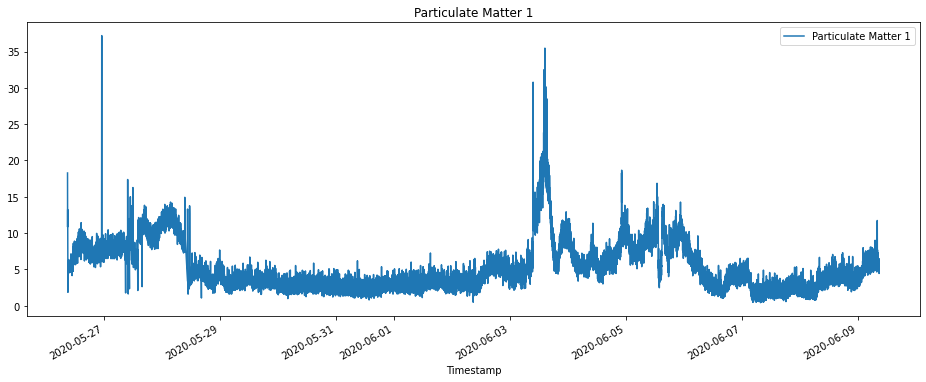

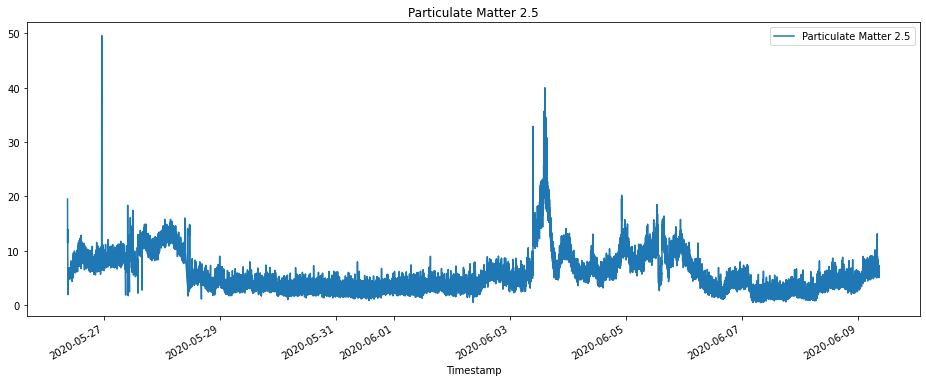

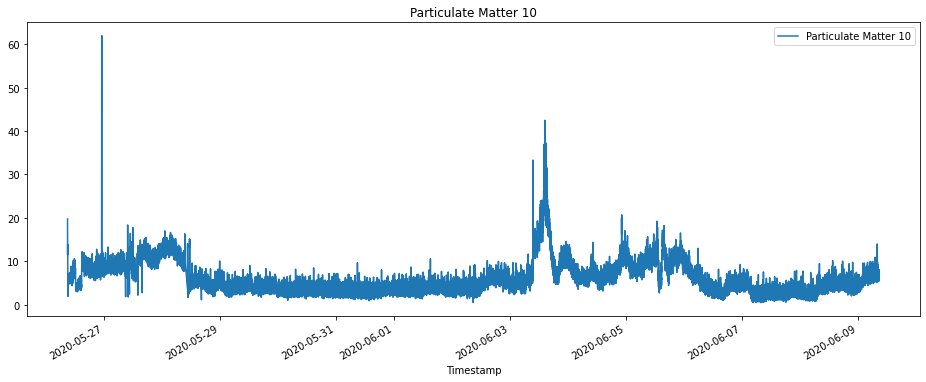

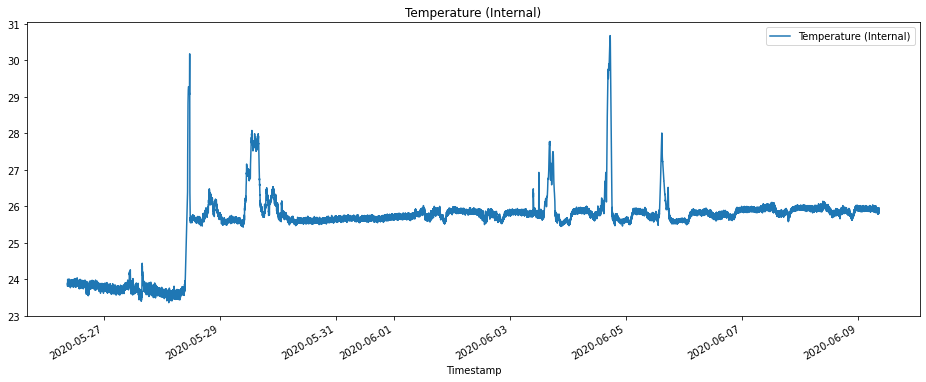

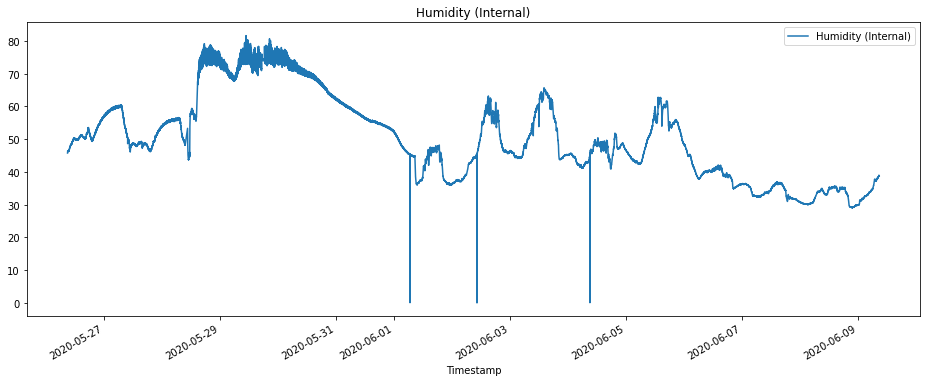

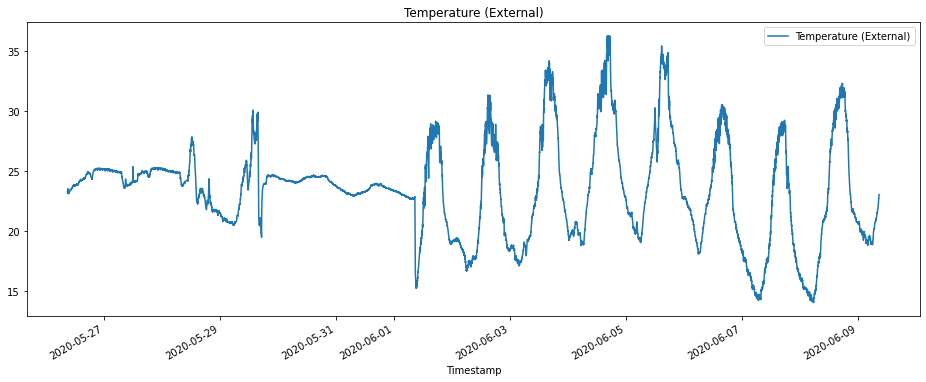

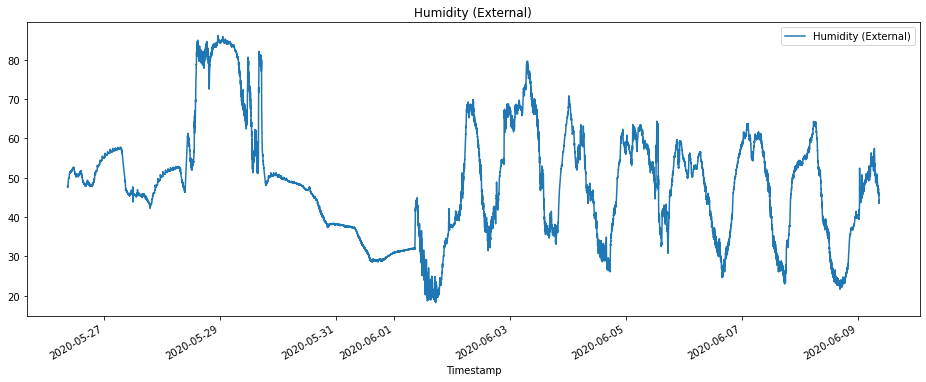

In [39]:
for col in data.columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    data.plot(y=col, use_index=True, ax=ax)
    ax.set_title(col)
plt.show()

### Correlation Plot

Correlation is a technique for investigating the relationship between two quantitative, continuous variables in order to represent their inter-dependencies. Among different correlation techniques, Pearson’s correlation is the most common one, which measures the strength of association between the two variables. Its correlation coefficient scales from -1 to 1, where 1 represents the strongest positive correlation, -1 represents the strongest negative correlation and 0 represents no correlation.

The correlation coefficients between each pair of the dataset are calculated and plotted as a heatmap. The scatter matrix of selected features is also plotted and attached in the Appendix section.


The first thing to be noticed is that PM 1, PM 2.5, and PM 10 are highly correlated with each other, which means they always fluctuate in the same fashion. Ozone is negatively correlated with Carbon Dioxide and positively correlates with Temperature (Internal) and Temperature (External). On the other hand, it is surprising not to find any significant correlation between Temperature (Internal) and Temperature (External), possibly due to the superior thermal insulation of the instrument. However, since there is no relevant knowledge provided, no conclusions can be made on the reasonability of this finding. 

Except for Ozone, Temperature (Internal) is also negatively correlated with Carbon Dioxide, Hydrogen Sulfide, and the three particulate matter measures. On the contrary, Temperature (External) positively correlates with Humidity (Internal) and three particulate matter measures, while negatively correlates with Humidity (External), just as what can be found from the time series plots in Figure 1.


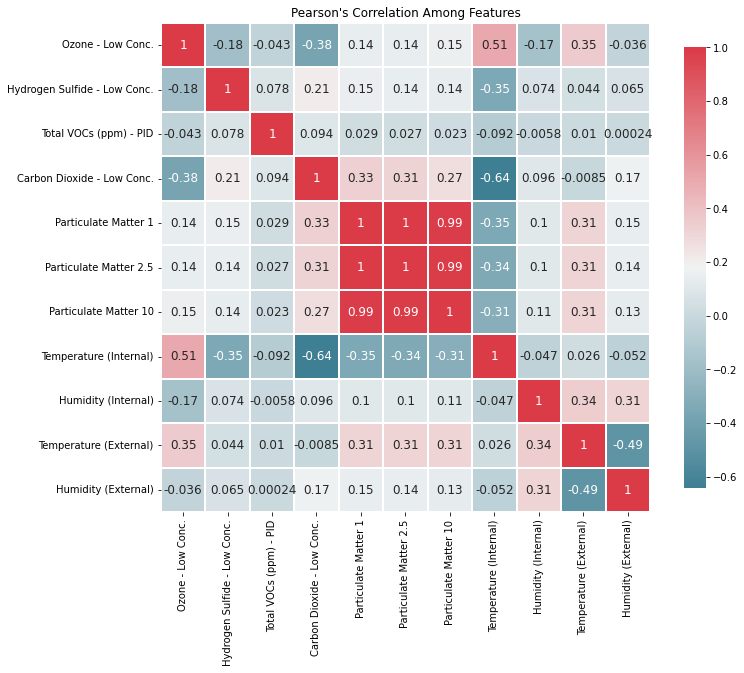

In [40]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
        data.corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.title("Pearson's Correlation Among Features")
plt.show()

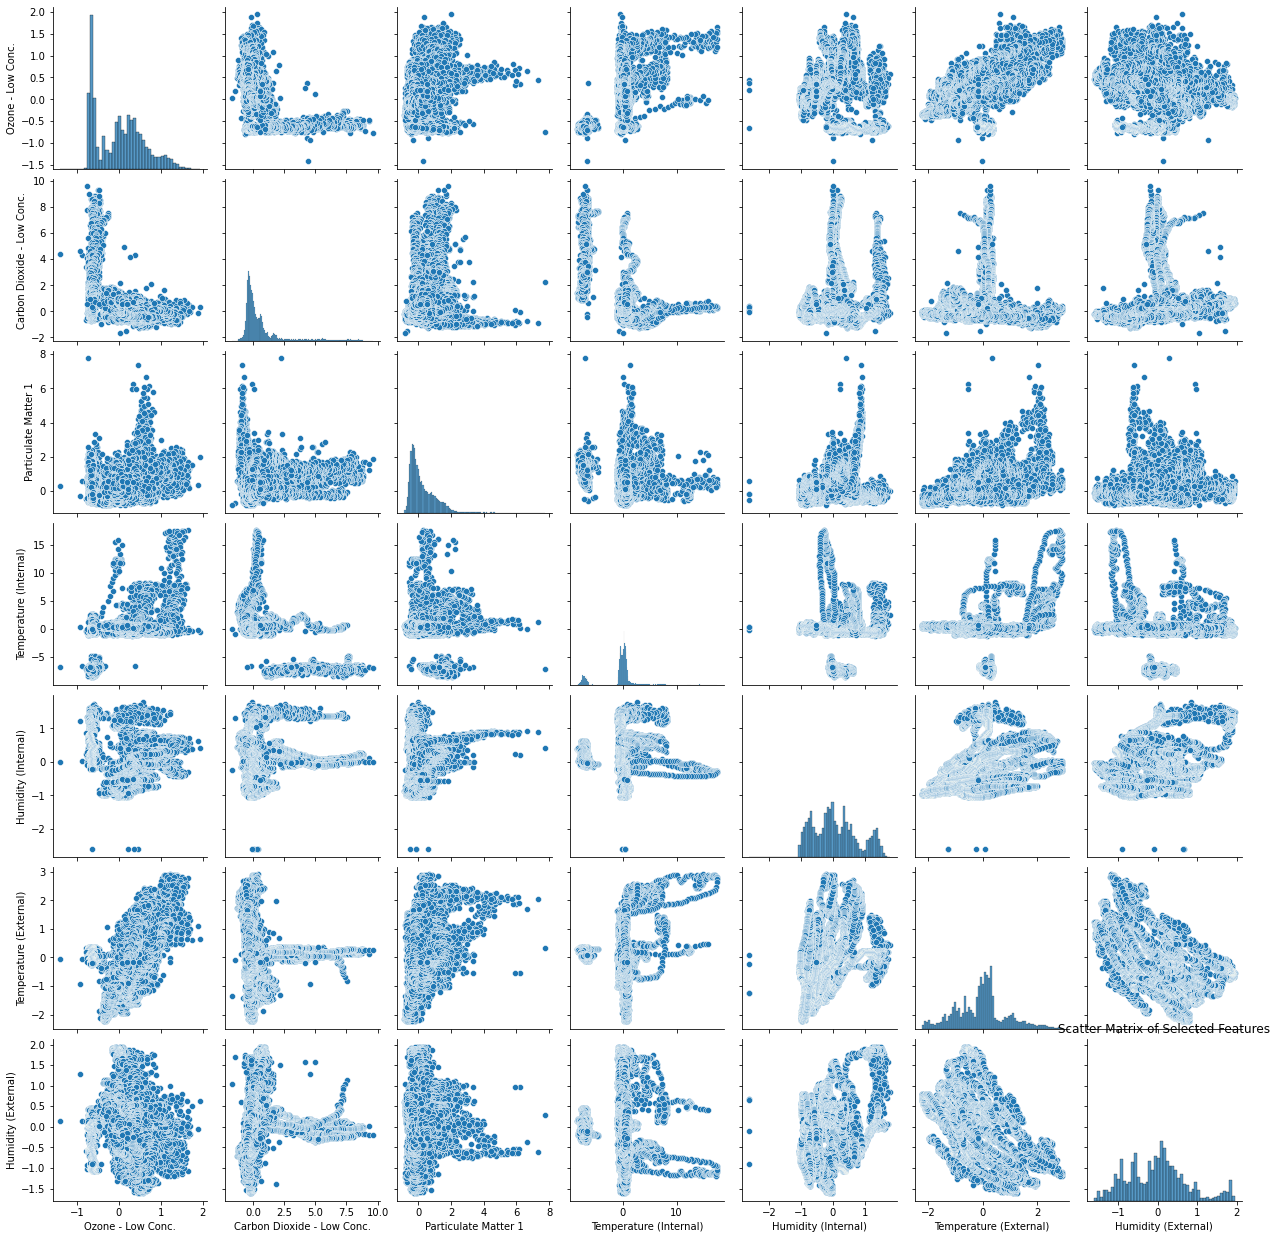

In [55]:
df = data_norm.iloc[:, [0, 3, 4, 7, 8, 9, 10]]
sns.pairplot(df)
plt.title("Scatter Matrix of Selected Features")
plt.show()

### Compare Toronto weather data with measurement

In [56]:
tw = pd.read_csv('data/weatherstats_toronto_hourly.csv')

In [57]:
tw['TimeStamp'] = pd.to_datetime(tw['unixtime'], unit='s')
tw.set_index('TimeStamp', inplace=True)
tw.index = tw.index.tz_localize('UTC').tz_convert('US/Eastern')
tw = tw[(tw.index >= '2020-05-26 09:00:00-04:00') & (tw.index <= '2020-06-09 09:00:00-04:00')]
tw = tw.iloc[::-1]

In [58]:
tw.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
TimeStamp,,,,,,,,,,,,,,,,,,,
2020-05-26 09:00:00-04:00,2020-05-26 09:00:00 EDT,1590498000,99.91,102.0,SSE,15,5,NaN,71,17.6,23.1,NaN,29.0,24100,3.5,NaN,7.0,NaN,NaN
2020-05-26 10:00:00-04:00,2020-05-26 10:00:00 EDT,1590501600,99.89,101.9,SSE,15,8,NaN,63,18.1,25.5,NaN,32.0,24100,3.5,NaN,3.0,NaN,NaN
2020-05-26 11:00:00-04:00,2020-05-26 11:00:00 EDT,1590505200,99.89,101.9,SE,14,13,NaN,61,17.9,25.9,NaN,32.0,24100,3.3,NaN,1.0,NaN,NaN
2020-05-26 12:00:00-04:00,2020-05-26 12:00:00 EDT,1590508800,99.89,101.9,SE,14,14,NaN,59,18.4,26.9,NaN,33.0,24100,3.3,NaN,1.0,NaN,NaN
2020-05-26 13:00:00-04:00,2020-05-26 13:00:00 EDT,1590512400,99.86,101.9,S,18,15,NaN,57,19.1,28.2,NaN,35.0,24100,3.3,NaN,1.0,NaN,NaN


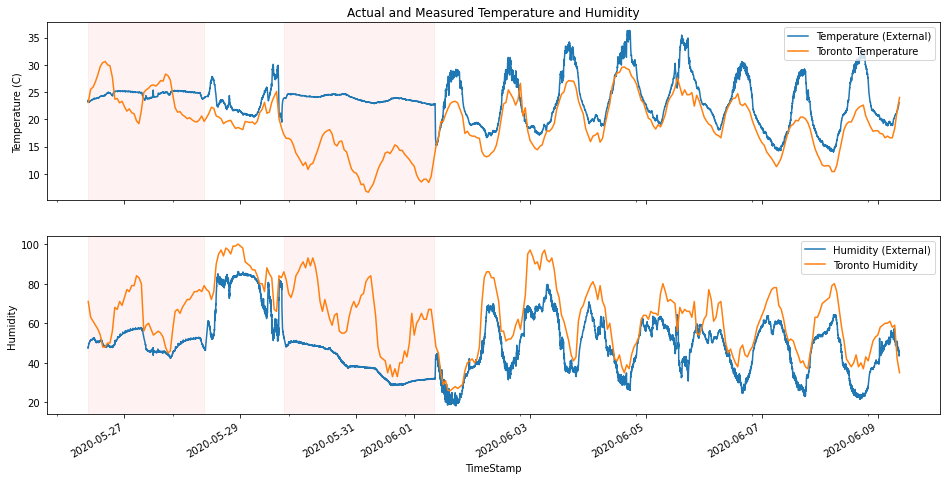

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
data.plot(y='Temperature (External)', use_index=True, ax=ax1, color='tab:blue')
tw.plot(y='temperature', use_index=True, ax=ax1, color='tab:orange', label='Toronto Temperature')
data.plot(y='Humidity (External)', use_index=True, ax=ax2, color='tab:blue')
tw.plot(y='relative_humidity', use_index=True, ax=ax2, color='tab:orange', label='Toronto Humidity')
ax1.set_ylabel('Temperature (C)')
ax2.set_ylabel('Humidity')
ax1.set_title('Actual and Measured Temperature and Humidity')
for ax in (ax1, ax2):
    ax.axvspan('2020-05-26 09:00:00-04:00', '2020-05-28 9:00:00-04:00', alpha=0.05, color='red')
    ax.axvspan('2020-05-29 18:00:00-04:00', '2020-06-01 8:00:00-04:00', alpha=0.05, color='red')
    ax.legend(loc='upper right')
plt.show()

According to common sense, the outdoor temperature reaches its high point at noon and goes down at night, I start to wonder the possibility that different test environments were involved during this 14-day period. To test the idea, Toronto weather data is queried from Canada Weather Stats. The temperature and relative humidity are overlaid and compared with the external temperature and humidity in this dataset.

It can be seen that the actual temperature and humidity fluctuate in a sinusoidal fashion. Most parts of the temperature and humidity readings correlate well with the weather data, while the areas highlighted in pink remains relatively invariant. I am not provided with any relevant information on the environments that the measurements were taken, but from the plot, it can be reasonably inferred that the device has been relocated between indoor and outdoor environments during the 14-day period. This is also tested later in the automatic anomaly detection in Section 3.3.

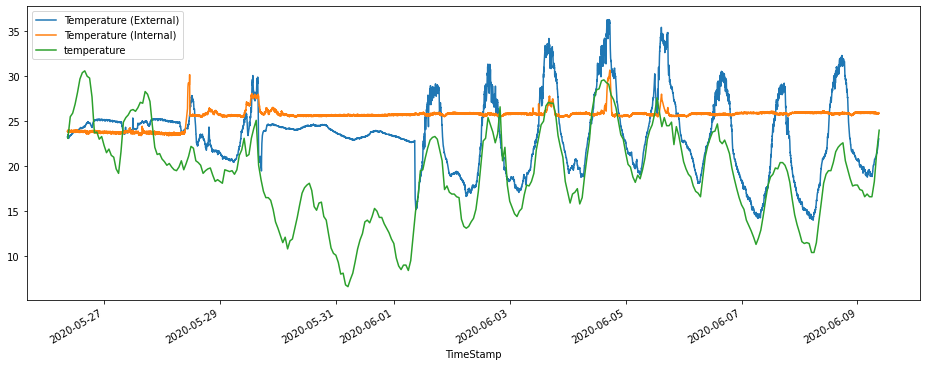

In [60]:
fig, ax = plt.subplots(figsize=(16, 6))
data.plot(y='Temperature (External)', use_index=True, ax=ax)
data.plot(y='Temperature (Internal)', use_index=True, ax=ax)
tw.plot(y='temperature', use_index=True, ax=ax)
plt.show()

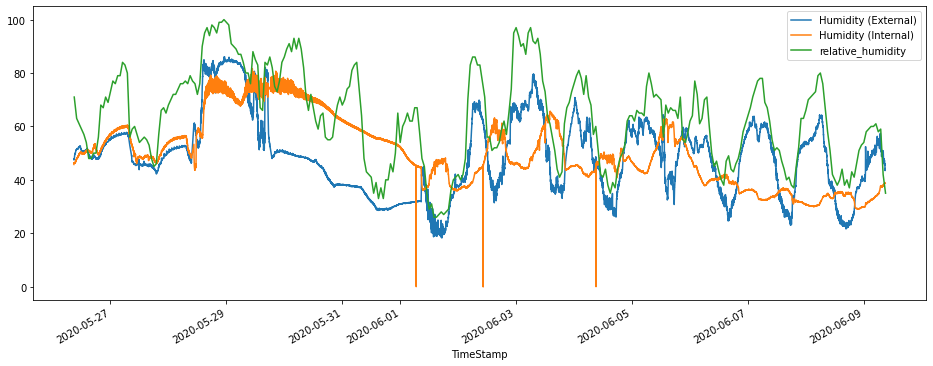

In [61]:
fig, ax = plt.subplots(figsize=(16, 6))
data.plot(y='Humidity (External)', use_index=True, ax=ax)
data.plot(y='Humidity (Internal)', use_index=True, ax=ax)
tw.plot(y='relative_humidity', use_index=True, ax=ax)
plt.show()

## Save preapared data

In [62]:
import pickle

In [64]:
with open('data/data_full.pkl', 'wb') as f:
    pickle.dump((data, data_norm), f)